In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
# Read the csv file and parse dates
dataset = pd.read_csv('pea_data_random_1000_rows.csv',
                      sep=';',
                      parse_dates=['due_date','date_planned_initial_end','date_target_end',
                                   'first_coil_end_date','first_coil_released_date',
                                   'first_coil_delivered_date','last_coil_end_date',
                                   'last_coil_released_date','last_coil_delivered_date'])

In [3]:
# Converting the categorical column datatype -> reduce the file size
dataset['steel_grade_int_text_en'] = dataset['steel_grade_int_text_en'].astype('category')
dataset['steel_grade_group_text'] = dataset['steel_grade_group_text'].astype('category')
dataset['value_name'] = dataset['value_name'].astype('category')

In [4]:
# Removing the columns with minimal variance 
dataset.drop(columns=['Unnamed: 0','customer_order_id','production_order_id','rh_mode','q2count',
                      'q3count','total_downgrade_weight','hr_downgrade_weight','hrgi_downgrade_weight',
                      'hrp_downgrade_weight','crfh_downgrade_weight','crfp_downgrade_weight',
                      'crca_downgrade_weight','crgi_downgrade_weight'],axis=1,inplace=True)

In [5]:
# Fetching the loc of columnns for categorical value to numerical value encoding
dataset.columns.get_loc('steel_grade_int_text_en')    #15
dataset.columns.get_loc('steel_grade_group_text')     #16
dataset.columns.get_loc('value_name')                 #20

# Converting the categorical -> numerical columns
label_encoder_x_1 = LabelEncoder() 
dataset.iloc[:,12] = label_encoder_x_1.fit_transform(dataset.iloc[:,12])

label_encoder_x_2 = LabelEncoder() 
dataset.iloc[:,13] = label_encoder_x_2.fit_transform(dataset.iloc[:,13])

label_encoder_x_3 = LabelEncoder() 
dataset.iloc[:,15] = label_encoder_x_3.fit_transform(dataset.iloc[:,15])

In [6]:
# Cast data type of date columns
# Work around for due_date as it was returing error
dataset['due_date'] = pd.to_datetime(dataset['due_date'],errors = 'coerce') #Out of bounds nanosecond timestamp
dataset['due_date'] = dataset['due_date'].values.astype('datetime64[D]') #Convert datatype into datetime64

dataset['date_planned_initial_end']=pd.to_datetime(dataset['date_planned_initial_end'])
dataset['date_target_end']=pd.to_datetime(dataset['date_target_end'])
dataset['first_coil_end_date']=pd.to_datetime(dataset['first_coil_end_date'])
dataset['first_coil_released_date']=pd.to_datetime(dataset['first_coil_released_date'])
dataset['first_coil_delivered_date']=pd.to_datetime(dataset['first_coil_delivered_date'])
dataset['last_coil_end_date']=pd.to_datetime(dataset['last_coil_end_date'])
dataset['last_coil_released_date']=pd.to_datetime(dataset['last_coil_released_date'])
dataset['last_coil_delivered_date']=pd.to_datetime(dataset['last_coil_delivered_date'])

In [7]:
# Taking difference (as number of days) between possible datetime columns instead of actual dates
dataset['difference_days_1'] = ((dataset['due_date']-dataset['date_planned_initial_end']).dt.days)
dataset['difference_days_2'] = (dataset['date_planned_initial_end']-dataset['date_target_end']).dt.days
dataset['difference_days_3'] = (dataset['due_date']-dataset['date_target_end']).dt.days
dataset['difference_days_4'] = (dataset['first_coil_end_date']-dataset['first_coil_released_date']).dt.days
dataset['difference_days_5'] = (dataset['first_coil_released_date']-dataset['first_coil_delivered_date']).dt.days
dataset['difference_days_6'] = (dataset['first_coil_end_date']-dataset['first_coil_delivered_date']).dt.days
dataset['difference_days_7'] = (dataset['last_coil_end_date']-dataset['last_coil_released_date']).dt.days
dataset['difference_days_8'] = (dataset['last_coil_released_date']-dataset['last_coil_delivered_date']).dt.days
dataset['difference_days_9'] = (dataset['last_coil_end_date']-dataset['last_coil_delivered_date']).dt.days

In [8]:
# Dropping the unrequired columns as the difference has already been calculated and respective new columns have been
# created with suffix difference_days_?
dataset.drop(columns=['due_date','date_planned_initial_end','date_target_end',
                                   'first_coil_end_date','first_coil_released_date',
                                   'first_coil_delivered_date','last_coil_end_date',
                                   'last_coil_released_date','last_coil_delivered_date'],axis=1,inplace=True)

In [9]:
# Function to convert all the column data types to string for data manipulation
def convert_to_string(s):
    if isinstance(s,object):
        return s
    elif isinstance(s,int):
        return s

for key,value in dataset.iteritems():
    dataset[key] = value.apply(convert_to_string)
    dataset[key] = value.astype(str)

In [10]:
# Function to replace , by . for further conversion to float64
def replace_comma(s):
    return s.replace(',','.')

for key,value in dataset.iteritems():
    dataset[key] = value.apply(replace_comma)

In [11]:
# Function to convert all the column data types to float64 for consistency
def to_float(s):
    if isinstance(s,object):
        return s

for key,value in dataset.iteritems():
    dataset[key] = value.apply(to_float)
    dataset[key] = value.astype(float)

In [12]:
# Restructuring the columns
cols = dataset.columns.to_list()
cols = cols[0:17] + cols[18:] + [cols[17]]
dataset = dataset.reindex(columns=cols)

(array([  1.,   1.,   1.,   2.,   7.,  16.,  83., 259., 512., 118.]),
 array([-19127261. , -16897139.4, -14667017.8, -12436896.2, -10206774.6,
         -7976653. ,  -5746531.4,  -3516409.8,  -1286288.2,    943833.4,
          3173955. ]),
 <a list of 10 Patch objects>)

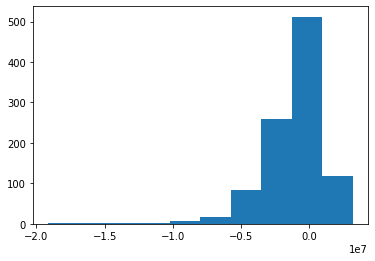

In [13]:
#Plotting to see the distribution 
plt.hist(dataset['lateness'])

In [14]:
# Update lateness column - assuming lateness<0 as 'late' and lateness>0 as 'not late'
# if lateness< 0 then update to 0 and if lateness>0 update to 1 for classification
import math
def update_lateness(value):
    return int(value>0)

dataset['lateness'] = dataset['lateness'].apply(update_lateness)

In [15]:
# Data Wrangling
# Infinite values were found, so removed them and also if there are any NaNs present on values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

In [16]:
#Removing outliers as it is affected by PCA
z_scores = stats.zscore(dataset)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
dataset = dataset[filtered_entries]

In [ ]:
#Pairplot for overview of correlations
sns.pairplot(dataset)

In [17]:
# Splitting the dataset into Independent variables and Dependent variable
x = dataset.iloc[:,0:26].values
y = dataset.iloc[:,26].values

# Fit and transform the categorical columns
onehotencoder = OneHotEncoder(categorical_features=[12])
x = onehotencoder.fit_transform(x).toarray()
# Removing dummy variable trap by eliminating the first column
x = x[:,1:]

# Fit and transform the categorical columns
onehotencoder = OneHotEncoder(categorical_features=[32])
x = onehotencoder.fit_transform(x).toarray()
# Removing dummy variable trap by eliminating the first column
x = x[:,1:]

# Fit and transform the categorical columns
onehotencoder = OneHotEncoder(categorical_features=[37])
x = onehotencoder.fit_transform(x).toarray()
# Removing dummy variable trap by eliminating the first column
x = x[:,1:]

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/Applications/Utilities/anaconda3/lib/python3.7/site-packages/sklearn/preproce

In [33]:
# Splitting the data into train-test set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)

# Feature Scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

array([0.03953772, 0.07629379, 0.11203272, 0.145428  , 0.17833765,
       0.2098889 , 0.24037968, 0.26997832, 0.29831657, 0.32597357,
       0.35232592, 0.37813509, 0.40290471, 0.42676861, 0.44978794,
       0.47271855, 0.49523549, 0.51743195, 0.53925117, 0.56062473,
       0.58129124, 0.60170978])

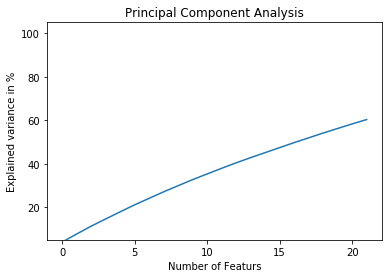

In [34]:
# Principal Component Analysis
pca = PCA(n_components = 22) #to see the variance 
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.xlabel('Number of Featurs')
plt.ylabel('Explained variance in %')
plt.ylim(5,105)
plt.title('Principal Component Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)

explained_variance.cumsum()
# Selecting n_components = 22 as it explains approx 60% of variance in dataset

In [23]:
classifier = SVC(C=1,kernel='rbf',random_state=0,gamma=0.001)
classifier.fit(x_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [25]:
# Creating a y_pred vector with predictions for test-set
y_pred = classifier.predict(x_test)

# Using confusion matrix for accuracy calculation
cm = confusion_matrix(y_test,y_pred)

# Calculating accuracy percentage
print('Accuracy using Confusion Matrix: ',((cm[0][0]+cm[1][1])*100/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])).round(2),'%')

Accuracy using Confusion Matrix:  64.88 %


In [27]:
# 10-fold Cross Validation
accuracies = cross_val_score(estimator=classifier,X=x_train,y=y_train,cv=10)

# Mean accuracy for all the folds
print('Mean accuracy using 10-fold Cross Validation: ',(accuracies.mean()*100),'%')
# -> 65.92%

# Standard Deviation
print('Standard Deviation: ',(accuracies.std()*100),'%')
# -> 0.33% SD 

Mean accuracy using 10-fold Cross Validation:  65.92259291776413 %
Standard Deviation:  0.003353902453124924 %


In [28]:
#grid search
#List of dictionaries, choose the parameters to optimize
parameters = [{'C':[1,10,100,1000],'kernel':['linear']},
              {'C':[1,10,100,1000],'kernel':['rbf'],'gamma':[0.1,0.01,0.001,0.2,0,3,0.4,0.5]},
              {'C':[1,10,100,1000],'kernel':['poly'],'gamma':[0.1,0.2,0,3,0.4,0.5,0.01,0.001],'degree':[2,3,4,5]}]
grid_search = GridSearchCV(estimator=classifier,param_grid=parameters,scoring='accuracy',cv=5,n_jobs=-1) 
grid_search = grid_search.fit(x_train,y_train)

/Applications/Utilities/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
best_accuracy = grid_search.best_score_
best_accuracy

0.6592261904761905

In [30]:
best_parameters = grid_search.best_params_
best_parameters

{'C': 1, 'kernel': 'linear'}

In [35]:
classifier = SVC(C=1,kernel='linear')
classifier.fit(x_train,y_train)

# Creating a y_pred vector with predictions for test-set
y_pred = classifier.predict(x_test)

# Using confusion matrix for accuracy calculation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

# Calculating accuracy percentage
print('Accuracy using Confusion Matrix: ',((cm[0][0]+cm[1][1])*100/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])).round(2),'%')

Accuracy using Confusion Matrix:  64.88 %


# Accuracy after Grid-Search Optimal Parameters    : 64.88 %
# Mean accuracy using 10-fold Cross Validation     : 65.92 %